In [1]:
from sklearn.metrics import adjusted_rand_score

# Assuming your clustering output is named 'clustering_output' and ground truth is named 'ground_truth'
clustering_output = [1, 2, 1, 1, 2, 2, 0]
ground_truth = [0, 1, 0, 0, 1, 1, 2]

# Calculate the ARI
ari = adjusted_rand_score(ground_truth, clustering_output)

# Print the ARI
print("ARI:", ari)

ARI: 1.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

In [3]:
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

In [4]:
spatial_label = pd.read_csv("/home/comp/cszrwang/data/MOB/mob_domain_k_means.csv", index_col=0)

In [5]:
spatial_label

x   y domain
0    17  17    GCL
1    18  17     GL
2    20  17    ONL
3    19  17    ONL
4    22  17    MCL
..   ..  ..    ...
277  19  27     GL
278  28  27     GL
279  24  29     GL
280  25  29     GL
281  30  19    ONL

[282 rows x 3 columns]

In [6]:
domain_indices = {
    'GCL': 0,
    'GL': 1,
    'MCL': 2,
    'ONL': 3
}
spatial_label['domain'] = spatial_label['domain'].map(domain_indices)
domain = np.array(spatial_label['domain'])
nan_indices = np.isnan(domain)
domain = domain[~nan_indices]
domain = domain.astype(int)
domain

array([0, 1, 3, 3, 2, 1, 2, 0, 2, 1, 3, 3, 3, 3, 3, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 3, 2, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 2, 1, 2, 2, 0, 0, 2, 1, 1, 1,
       2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 3, 1, 2, 1, 1, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1,
       2, 2, 1, 1, 2, 1, 2, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 1,
       1, 1, 2, 2, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 2, 1, 2, 1, 1, 3, 0, 0,
       0, 0, 1, 2, 2, 1, 1, 2, 0, 0, 1, 0, 3, 3, 1, 3, 2, 2, 3, 1, 3, 3,
       3, 3, 1, 2, 0, 2, 2, 1, 3, 3, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0, 2, 2,
       0, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3])

In [7]:
def k_means(df, k):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(df)

    # Perform one-hot encoding on the cluster labels
    encoder = OneHotEncoder(sparse=False)
    cluster_vectors = encoder.fit_transform(clusters.reshape(-1, 1))
    
    # Get the numeric cluster labels
    numeric_labels = kmeans.labels_

    # Display the cluster vectors
    return cluster_vectors, numeric_labels

In [8]:
def purity(clustering_output, ground_truth):
    # Create the contingency table
    contingency_table = np.zeros((len(np.unique(clustering_output)), len(np.unique(ground_truth))))
    for i in range(len(clustering_output)):
        clustering_label = clustering_output[i]
        ground_truth_label = ground_truth[i]
#         print(clustering_label)
#         print(ground_truth_label)
        contingency_table[clustering_label][ground_truth_label] += 1

    # Calculate the purity
    purity = np.sum(np.amax(contingency_table, axis=0)) / len(clustering_output)
    return purity

In [9]:
def draw_pie(dist, xpos, ypos, size, colors, ax):

    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    i = 0
    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2, num=100)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        ax.scatter([xpos], [ypos], marker=xy, s=size, c=colors[i], edgecolors='none')
        i += 1

    return ax

def plot_frac_results(predict, cell_type_list, coordinates, file_name=None, point_size=1000, size_coefficient=0.0009, if_show=True, color_dict=None):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    labels = cell_type_list
    if color_dict != None:
        colors = []
        for i in cell_type_list:
            colors.append(color_dict[i])
    else:
        if len(labels) <= 10:
            colors = plt.rcParams["axes.prop_cycle"].by_key()['color'][:len(labels)]
        else:
            import matplotlib
            color = plt.get_cmap('rainbow', len(labels))
            colors = []
            for x in color([range(len(labels))][0]):
                colors.append(matplotlib.colors.to_hex(x, keep_alpha=False))
    
    str_len = 0
    for item in cell_type_list:
        str_len = max(str_len, len(item))
    extend_region = str_len/15+1
    
    
    fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+extend_region, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
    
    for i in tqdm(range(predict.shape[0]), desc="Plotting pie plots:"):
        ax = draw_pie(predict[i], coordinates['coor_X'].values[i], coordinates['coor_Y'].values[i], 
                                              size=point_size, ax=ax, colors=colors)
        
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')  # Set edge line color of all spines to grey
    
    
    patches = [mpatches.Patch(color=colors[i], label="{:s}".format(labels[i]) ) for i in range(len(colors))]
    fontsize = max(predict.shape[0]/100, 10)
    fontsize = min(fontsize, 30)
    ax.legend(handles=patches, fontsize=fontsize, bbox_to_anchor=(1, 1), loc="upper left")
    plt.axis("equal")
#     plt.edgecolors("lightgrey")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name, 
                    dpi=300, 
#                     bbox_inches='tight'
                   )
    if if_show == True:
        plt.show()
    plt.close('all')
    
    
    
def plot_scatter_by_type(predict, cell_type_list, coordinates, point_size=400, size_coefficient=0.0009, file_path=None, if_show=True):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    
    for i in tqdm(range(len(cell_type_list)), desc="Plotting cell type scatter plot:"):
        
        fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+1, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
        cm = plt.cm.get_cmap('Reds')
        ax = plt.scatter(coordinates['coor_X'], coordinates['coor_Y'], s=point_size, vmin=0, vmax=1, c=predict[:, i], cmap=cm)

        cbar = plt.colorbar(ax, fraction=0.05)
        labelsize = max(predict.shape[0]/100, 10)
        labelsize = min(labelsize, 30)
        cbar.ax.tick_params(labelsize=labelsize)
        plt.axis("equal")
        plt.xticks([])
        plt.yticks([])
        plt.xlim(coordinates['coor_X'].min()-0.5, coordinates['coor_X'].max()+0.5)
        plt.ylim(coordinates['coor_Y'].min()-0.5, coordinates['coor_Y'].max()+0.5)
        plt.tight_layout()
        if file_path != None:
            name = cell_type_list[i].replace('/', '_')
            plt.savefig(file_path+'/{}.jpg'.format(name), dpi=300, bbox_inches='tight')
        if if_show == True:
            plt.show()
        plt.close('all')

In [10]:
ari_list = []
pur_list = []
labels = []

In [11]:
import warnings

# Disable all warning messages
warnings.filterwarnings("ignore")

In [12]:
## manually sort by excels
gmgcn = pd.read_csv("/home/comp/cszrwang/project/GMGAT4Deconv/figures/mean_out_mob_direct_20_seed1.model.csv")
cluster_vectors, numeric_labels = k_means(gmgcn, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
ari_list.append(ari)
ari

0.6261149087504866

In [13]:
pur = purity(domain, numeric_labels)
pur_list.append(pur)
pur

0.8381294964028777

In [14]:
k_means_df = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
k_means_df_filter = k_means_df[~nan_indices]
# k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/GMGCN/mob_k_means.csv", index=None)
labels.append("HarmoDecon")

In [15]:
coordinates = spatial_label[['x', 'y']]
output_dir = '/home/comp/cszrwang/results/Deconvolution/results/MOB/Figures'
cell_type_list = gmgcn.columns.to_list()
domain_list = ['0', '1', '2', '3']

In [17]:
color_dict = {'EPL-IN': '#CFA6B2', 'GC': '#FCD4C7', 'M/TC': '#6D889F', 'OSNs': '#F47C50',
             'PGC': '#A8AF7F'}

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

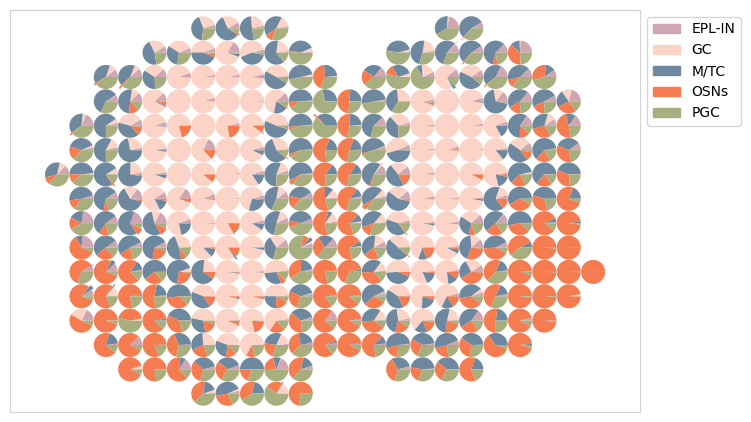

In [18]:
plot_frac_results(np.array(gmgcn), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/harmodecon_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

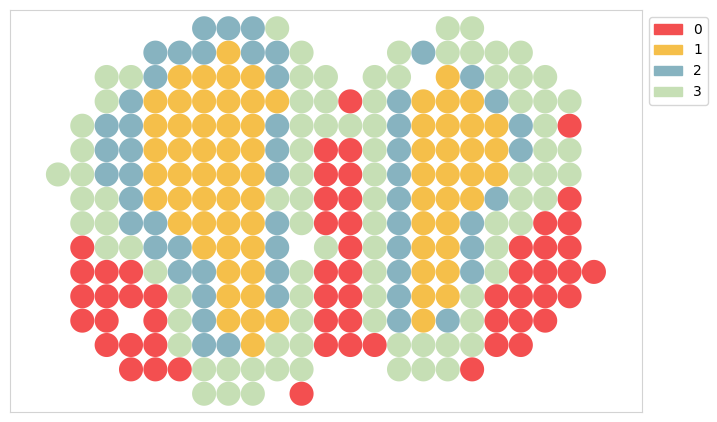

In [19]:
color_dict_domain = {'1': '#F5BF4A', '3': '#C6DFB5', '2': '#87B3C0', '0': '#F34F50'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/harmodecon_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [20]:
## manually sort by excels
card = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/CARD/CARD_output_mob.csv")
card = card.loc[:,np.unique(card.columns)]
cluster_vectors, numeric_labels = k_means(card, 4)
# numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
ari

0.4789266433066731

In [21]:
pur = purity(domain, numeric_labels)
pur

0.7302158273381295

In [22]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("CARD")

In [23]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/CARD/mob_k_means_card.csv", index=None)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

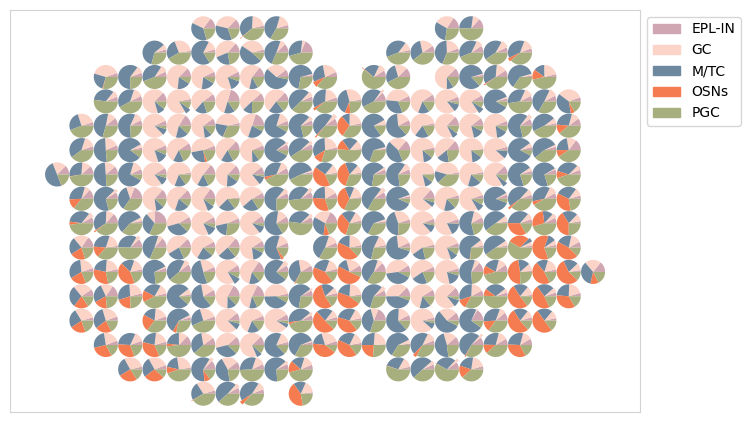

In [23]:
plot_frac_results(np.array(card), cell_type_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/card_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

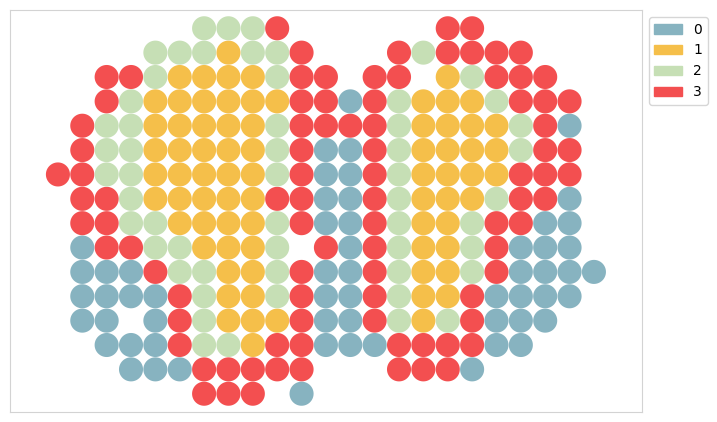

In [24]:
color_dict_domain = {'1': '#F5BF4A', '3': '#F34F50', '2': '#C6DFB5', '0': '#87B3C0'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/card_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [25]:
## manually sort by excels
rctd = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/RCTD/RCTD_output_mob.csv", index_col=0)
rctd = rctd.loc[:,np.unique(rctd.columns)]
cluster_vectors, numeric_labels = k_means(rctd, 4)
# numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.43639481655095236
0.7014388489208633


In [26]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("RCTD")

In [27]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/RCTD/mob_k_means_rctd.csv", index=None)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

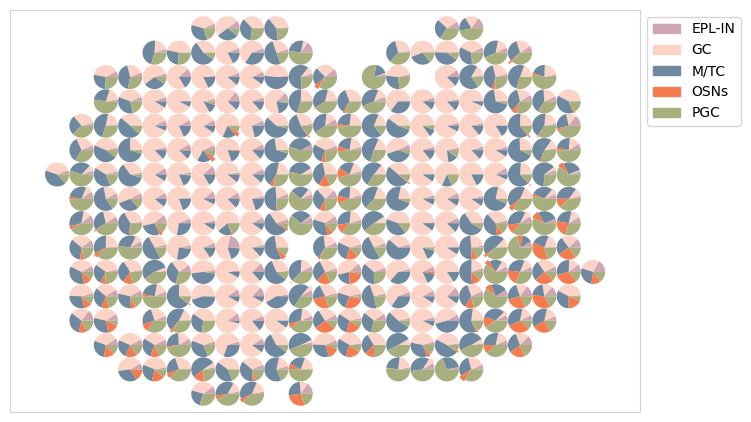

In [28]:
plot_frac_results(np.array(rctd), cell_type_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/rctd_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

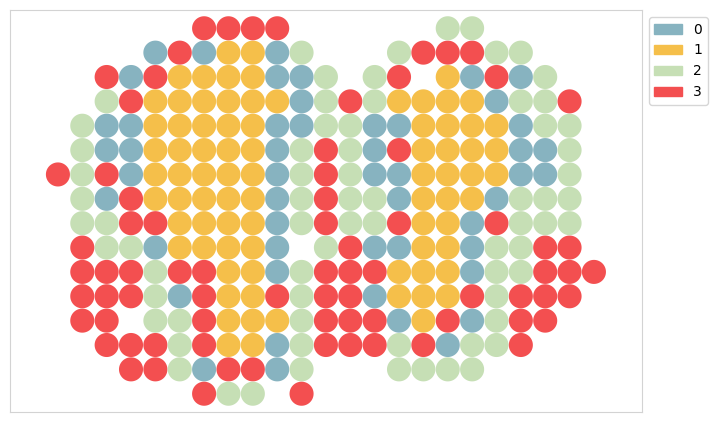

In [29]:
color_dict_domain = {'1': '#F5BF4A', '3': '#F34F50', '2': '#C6DFB5', '0': '#87B3C0'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/rctd_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [30]:
## manually sort by excels
stdgcn = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/StdGCN/mob_std.csv")
stdgcn = stdgcn.loc[:,np.unique(stdgcn.columns)]
cluster_vectors, numeric_labels = k_means(stdgcn, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.3282880093090122
0.5971223021582733


In [31]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("STdGCN")

In [32]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/StdGCN/mob_k_means_std.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

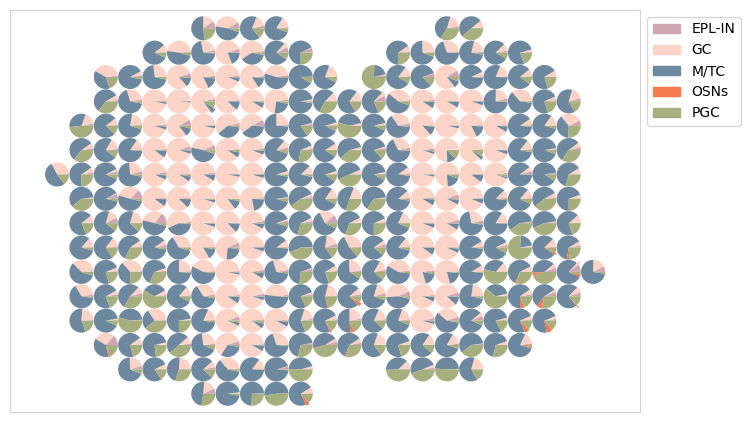

In [33]:
plot_frac_results(np.array(stdgcn), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/stdgcn_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

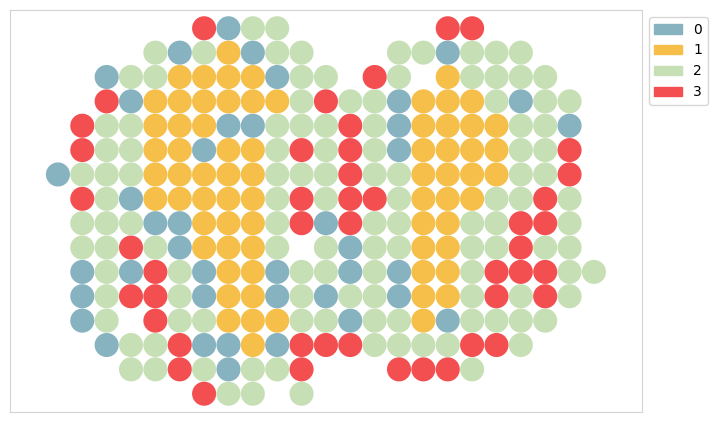

In [34]:
color_dict_domain = {'1': '#F5BF4A', '3': '#F34F50', '2': '#C6DFB5', '0': '#87B3C0'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/stdgcn_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [35]:
## manually sort by excels
spacel = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/SPACEL/SPACEL_result.csv", index_col=0)
spacel = spacel.loc[:,np.unique(spacel.columns)]
cluster_vectors, numeric_labels = k_means(spacel, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 280 but corresponding boolean dimension is 282

In [36]:
spacel['x'] = spacel.index.map(lambda x: int(x.split('x')[0]))
spacel['y'] = spacel.index.map(lambda x: int(x.split('x')[1]))
spacel

EPL-IN        GC      M/TC      OSNs       PGC   x   y
17x17  0.027894  0.790429  0.174712  0.000000  0.000000  17  17
18x17  0.216237  0.121071  0.406782  0.033223  0.222687  18  17
20x17  0.172796  0.165138  0.357678  0.248388  0.056000  20  17
19x17  0.211141  0.177339  0.297724  0.258092  0.055705  19  17
22x17  0.017492  0.337095  0.639230  0.000000  0.000000  22  17
...         ...       ...       ...       ...       ...  ..  ..
19x27  0.236120  0.229130  0.304568  0.014663  0.215519  19  27
28x27  0.185020  0.163427  0.288859  0.000000  0.360567  28  27
24x29  0.199299  0.206729  0.315397  0.000000  0.278373  24  29
25x29  0.205827  0.182138  0.298607  0.000000  0.313323  25  29
30x19  0.281563  0.104385  0.370859  0.146970  0.096224  30  19

[280 rows x 7 columns]

In [37]:
domain_label_loc = spatial_label[~nan_indices]
domain_label_loc

x   y  domain
0    17  17     0.0
1    18  17     1.0
2    20  17     3.0
3    19  17     3.0
4    22  17     2.0
..   ..  ..     ...
277  19  27     1.0
278  28  27     1.0
279  24  29     1.0
280  25  29     1.0
281  30  19     3.0

[278 rows x 3 columns]

In [38]:
spacel_x = pd.merge(domain_label_loc, spacel, on=['x','y'], how='left')
spacel_x = spacel_x[['EPL-IN','GC','M/TC','OSNs','PGC']]
spacel_x

EPL-IN        GC      M/TC      OSNs       PGC
0    0.027894  0.790429  0.174712  0.000000  0.000000
1    0.216237  0.121071  0.406782  0.033223  0.222687
2    0.172796  0.165138  0.357678  0.248388  0.056000
3    0.211141  0.177339  0.297724  0.258092  0.055705
4    0.017492  0.337095  0.639230  0.000000  0.000000
..        ...       ...       ...       ...       ...
273  0.236120  0.229130  0.304568  0.014663  0.215519
274  0.185020  0.163427  0.288859  0.000000  0.360567
275  0.199299  0.206729  0.315397  0.000000  0.278373
276  0.205827  0.182138  0.298607  0.000000  0.313323
277  0.281563  0.104385  0.370859  0.146970  0.096224

[278 rows x 5 columns]

In [39]:
cluster_vectors, numeric_labels = k_means(spacel_x, 4)
# numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.5802338113792568
0.8057553956834532


In [40]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("SPACEL")

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

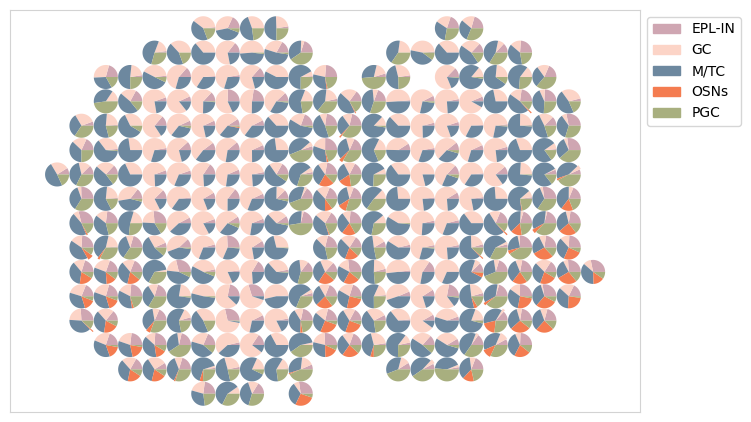

In [41]:
plot_frac_results(np.array(spacel_x), cell_type_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spacel_results_pie_plot.jpg', color_dict=color_dict)

In [42]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/SPACEL/mob_k_means_spacel.csv", index=None)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

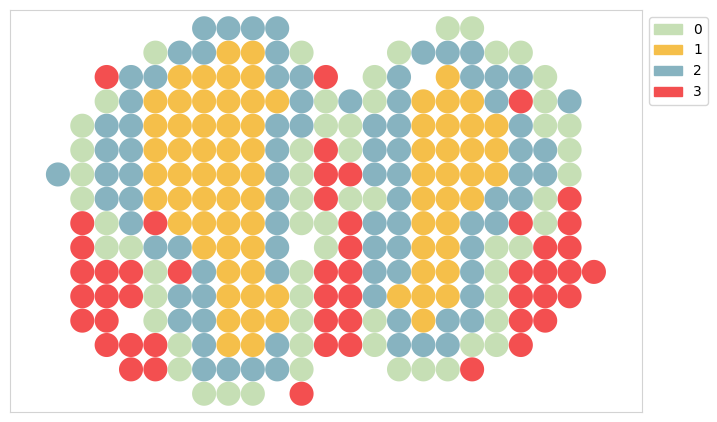

In [43]:
color_dict_domain = {'1': '#F5BF4A', '3': '#F34F50', '2': '#87B3C0', '0': '#C6DFB5'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spacel_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [44]:
dwls = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/SpatialDWLS/mob_dwls.csv")
dwls = dwls.loc[:,np.unique(dwls.columns)]
cluster_vectors, numeric_labels = k_means(dwls, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.4735382454110238
0.7230215827338129


In [45]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("SpatialDWLS")

In [46]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/SpatialDWLS/mob_k_means_dwls.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

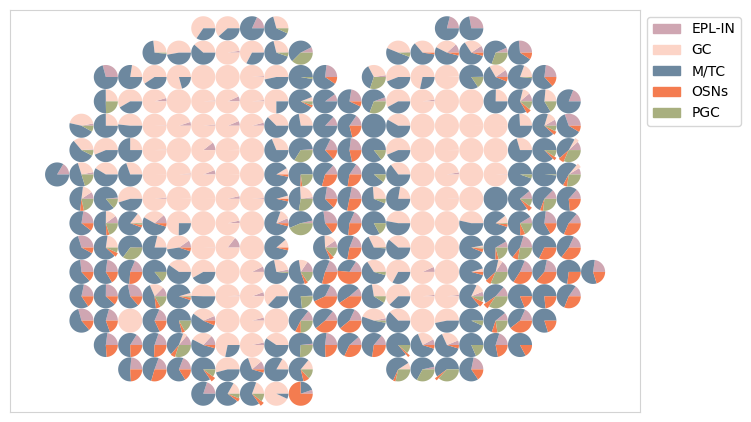

In [47]:
plot_frac_results(np.array(dwls), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/dwls_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/278 [00:00<?, ?it/s]

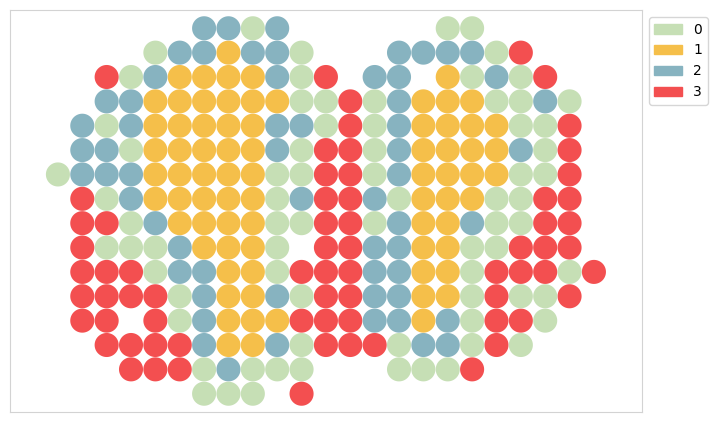

In [48]:
color_dict_domain = {'1': '#F5BF4A', '3': '#F34F50', '2': '#87B3C0', '0': '#C6DFB5'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates[~nan_indices], point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/dwls_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [49]:
redeconve = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Redeconve/Redeconve.csv", index_col=0)
redeconve = redeconve.loc[:,np.unique(redeconve.columns)]
cluster_vectors, numeric_labels = k_means(redeconve, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.36827038607080637
0.6330935251798561


In [50]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("Redeconve")

In [51]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Redeconve/mob_k_means_redeconve.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

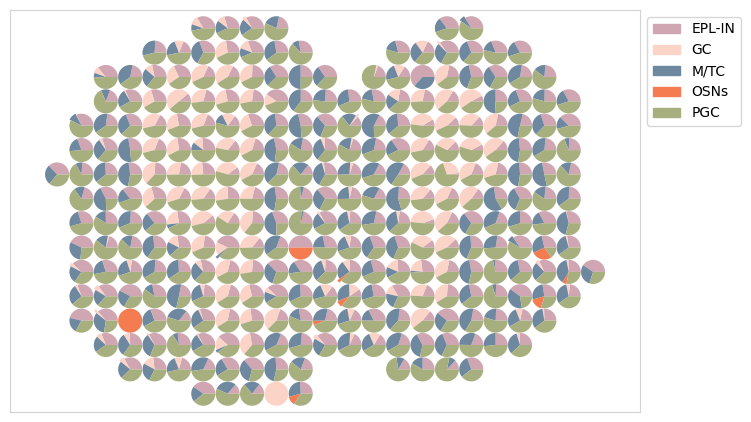

In [52]:
plot_frac_results(np.array(redeconve), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/redeconve_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

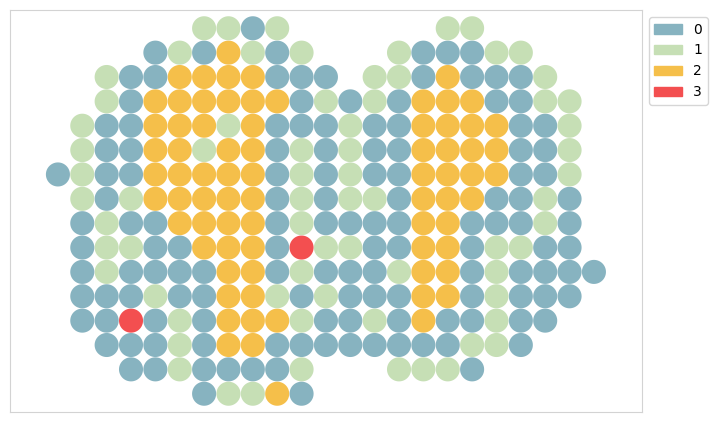

In [53]:
color_dict_domain = {'1': '#C6DFB5', '3': '#F34F50', '2': '#F5BF4A', '0': '#87B3C0'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/redeconve_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [54]:
import matplotlib.pyplot as plt

In [55]:
output_dir = '/home/comp/cszrwang/results/Deconvolution/results/MOB/Figures'

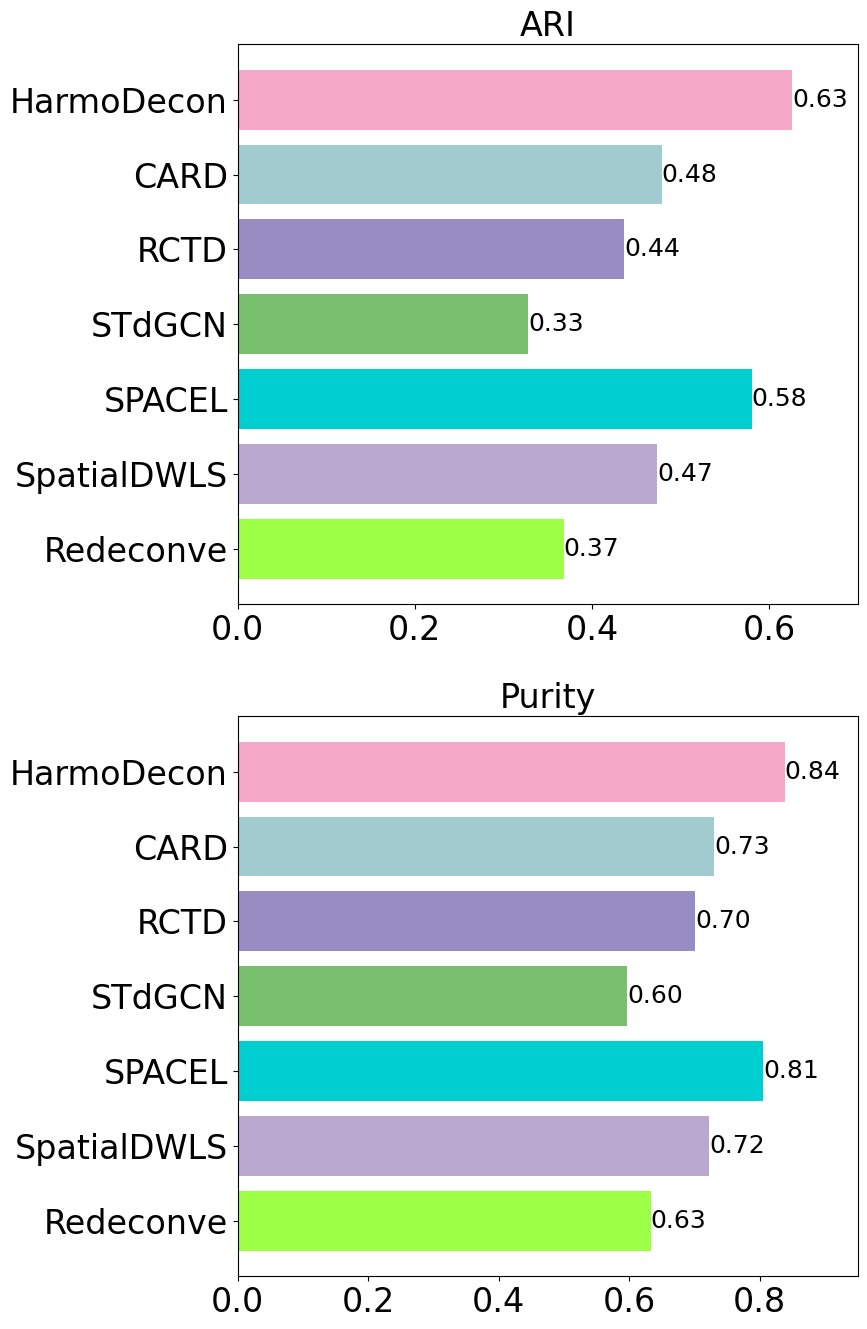

In [56]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 16))

# Given list
colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1',"#BBA8D1", "#9dff46"]
# labels = ['HarmoDecon','SPACEL','StdGCN','Redeconve','RCTD','SpatialDWLS','CARD']

# ari_list = [0.63, 0.58, 0.33, 0.37, 0.44, 0.47, 0.48]

# purity_list = [0.84, 0.81, 0.60, 0.63, 0.70, 0.72, 0.73]

# Create a horizontal bar graph with custom colors
bars = axes[0].barh(labels[::-1], ari_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars:
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)

axes[0].set_title("ARI", fontsize=24)
axes[0].set_ylabel('', fontsize=14)  # Remove y-label title

bars_p = axes[1].barh(labels[::-1], pur_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars_p:
    width = bar.get_width()
    if width < 0:
        axes[1].text(0, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)
    else:
        axes[1].text(width, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)

axes[1].set_title("Purity", fontsize=24)
axes[1].set_ylabel('', fontsize=14)  # Remove y-label title

axes[0].set_yticklabels(labels[::-1], fontsize=24)  # Increase fontsize to 14
axes[0].set_xlim([0, 0.7])  # Increase fontsize to 14
axes[1].set_xlim([0, 0.95])  # Increase fontsize to 14
axes[1].set_yticklabels(labels[::-1], fontsize=24)  # Increase fontsize to 14
for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='x', labelsize=24)

plt.savefig(output_dir + '/barsh.jpg', dpi=300, bbox_inches='tight')
# Display the graph
plt.show()

In [57]:
cell2location = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Cell2location/Cell2location_result.csv", index_col=0)
cell2location = cell2location.loc[:,np.unique(cell2location.columns)]
cluster_vectors, numeric_labels = k_means(cell2location, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.20642108780234955
0.5179856115107914


In [58]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("Cell2location")

In [59]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Cell2location/mob_k_means_cell2location.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

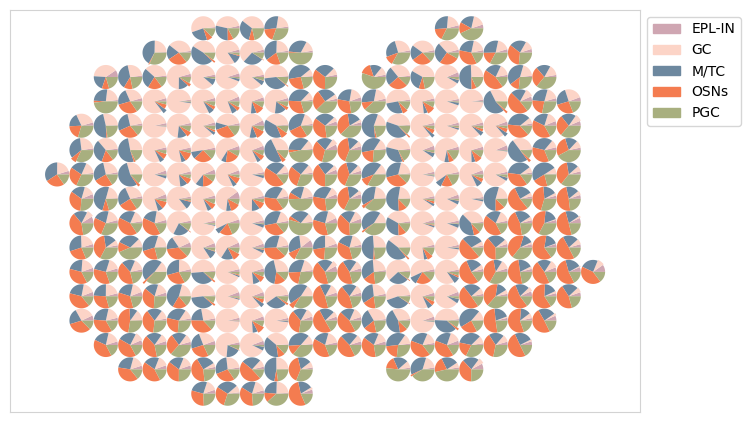

In [60]:
plot_frac_results(np.array(cell2location), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/cell2location_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

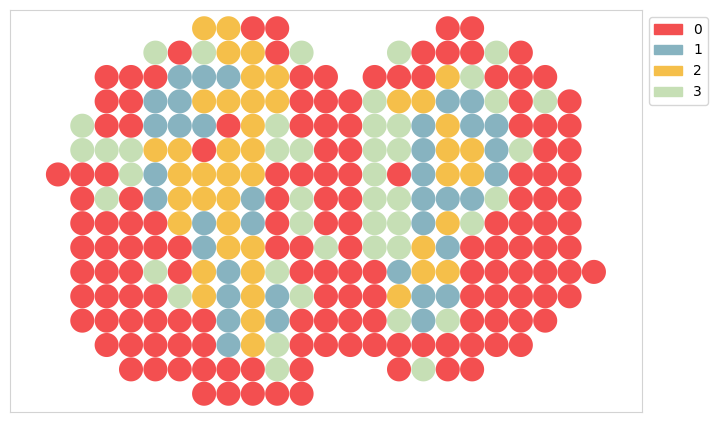

In [61]:
color_dict_domain = {'1': '#87B3C0', '3': '#C6DFB5', '2': '#F5BF4A', '0': '#F34F50'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/cell2location_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [62]:
dstg = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/DSTG/predict_output.csv", index_col=0)
dstg = dstg.loc[:,np.unique(dstg.columns)]
cluster_vectors, numeric_labels = k_means(dstg, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.2380375885319741
0.539568345323741


In [63]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("DSTG")

In [64]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/DSTG/mob_k_means_dstg.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

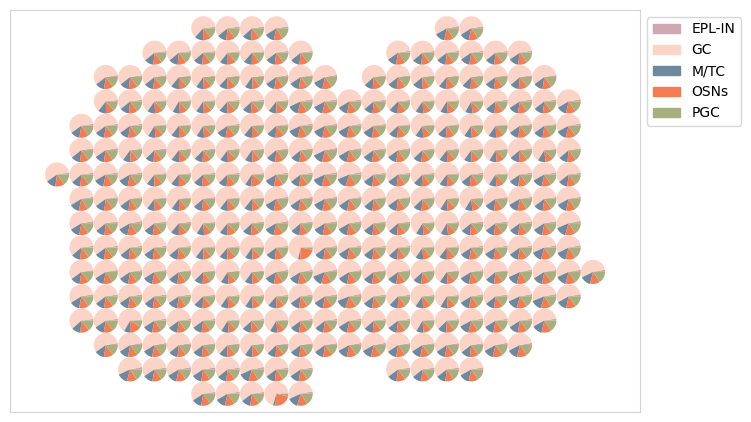

In [65]:
plot_frac_results(np.array(dstg), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/dstg_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

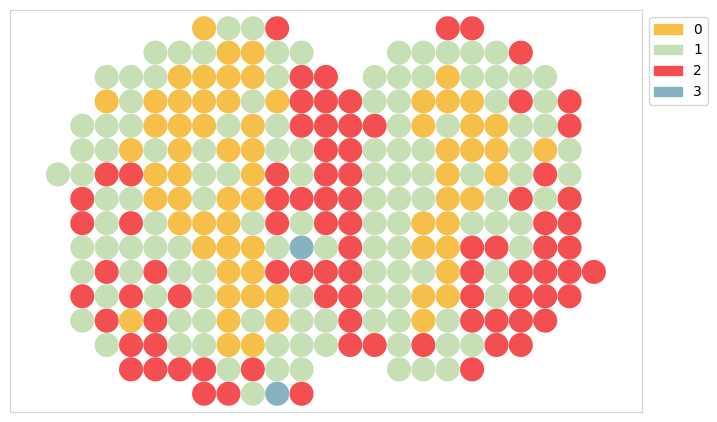

In [66]:
color_dict_domain = {'3': '#87B3C0', '1': '#C6DFB5', '0': '#F5BF4A', '2': '#F34F50'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/dstg_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [67]:
spotlight = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/SPOTlight/mob_SPOTlight.csv", index_col=0)
spotlight = spotlight.loc[:,np.unique(spotlight.columns)]
spotlight = spotlight.fillna(0)
cluster_vectors, numeric_labels = k_means(spotlight, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.366748747633896
0.6223021582733813


In [68]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("Spotlight")

In [69]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/SPOTlight/mob_k_means_spotlight.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

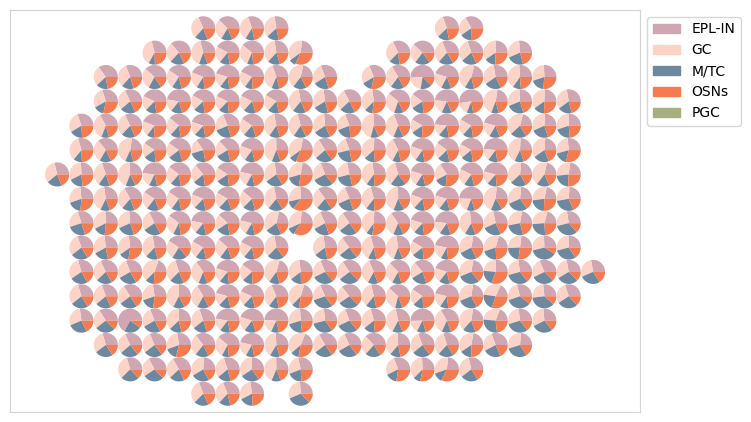

In [70]:
plot_frac_results(np.array(spotlight), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spotlight_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

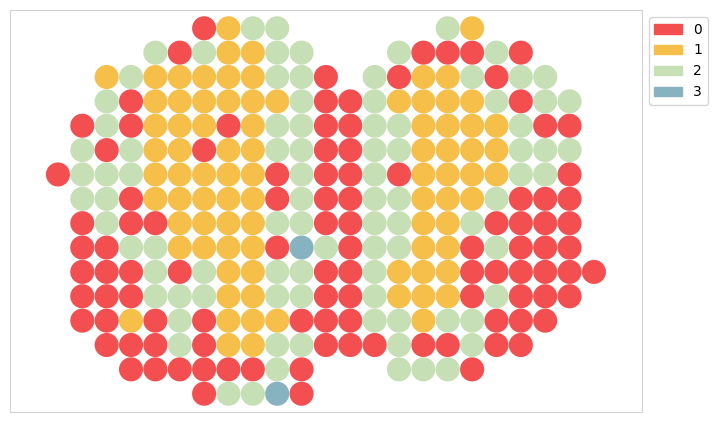

In [71]:
color_dict_domain = {'3': '#87B3C0', '2': '#C6DFB5', '1': '#F5BF4A', '0': '#F34F50'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spotlight_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [72]:
stereoscope = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Stereoscope/Stereoscope_result.csv", index_col=0)
stereoscope = stereoscope.loc[:,np.unique(stereoscope.columns)]
stereoscope = stereoscope.fillna(0)
cluster_vectors, numeric_labels = k_means(stereoscope, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.3581754717194989
0.6366906474820144


In [73]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("stereoscope")

In [74]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Stereoscope/mob_k_means_stereoscope.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

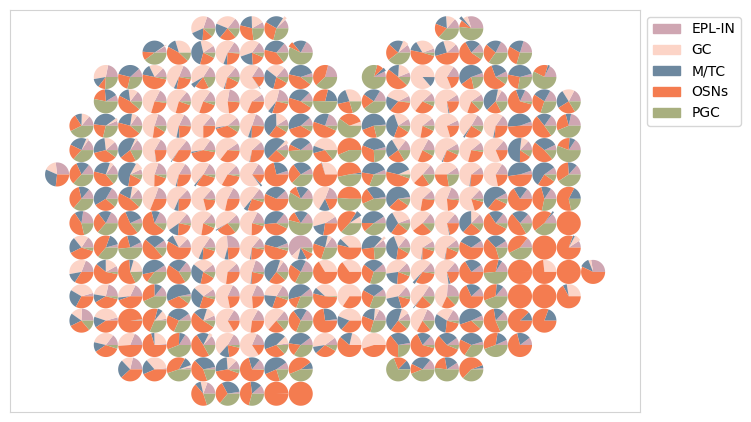

In [75]:
plot_frac_results(np.array(stereoscope), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/stereoscope_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

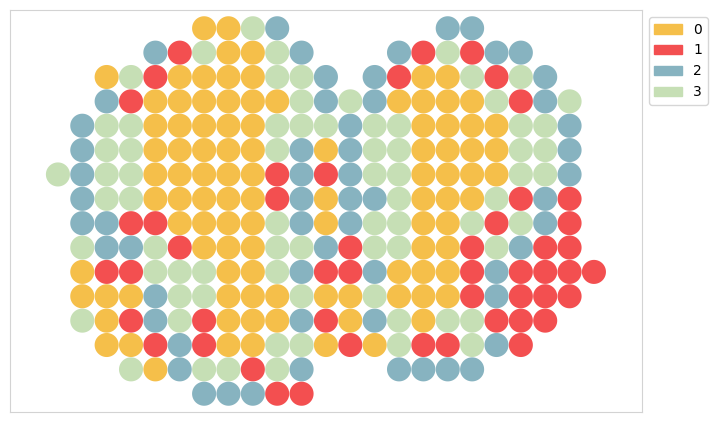

In [76]:
color_dict_domain = {'2': '#87B3C0', '3': '#C6DFB5', '0': '#F5BF4A', '1': '#F34F50'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/stereoscope_domains_pie_plot.jpg', color_dict=color_dict_domain)

In [77]:
tangram = pd.read_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Tangram/Tangram_result.csv", index_col=0)
tangram = tangram.loc[:,np.unique(tangram.columns)]
tangram = tangram.fillna(0)
cluster_vectors, numeric_labels = k_means(tangram, 4)
numeric_labels = numeric_labels[~nan_indices]
ari = adjusted_rand_score(domain, numeric_labels)
print(ari)
pur = purity(domain, numeric_labels)
print(pur)

0.31496262458940016
0.60431654676259


In [78]:
ari_list.append(ari)
pur_list.append(pur)
labels.append("Tangram")

In [79]:
k_means_df_filter = pd.DataFrame(cluster_vectors, columns=[i for i in range(len(cluster_vectors[0]))])
# k_means_df_filter = k_means_df_filter[~nan_indices]
k_means_df_filter.columns = domain_indices.keys()
k_means_df_filter.to_csv("/home/comp/cszrwang/results/Deconvolution/results/MOB/Tangram/mob_k_means_tangram.csv", index=None)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

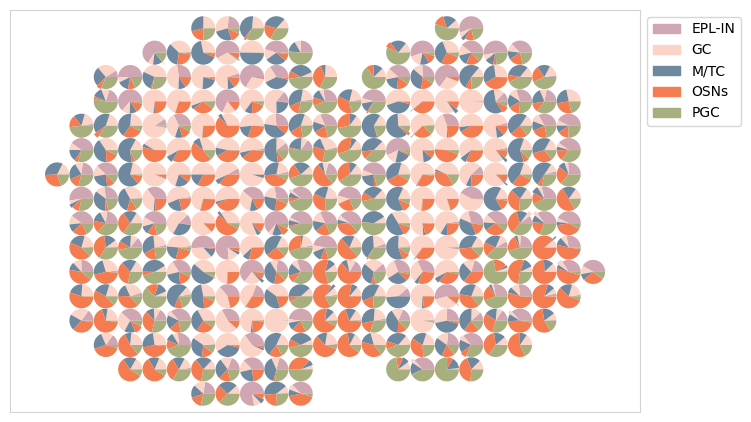

In [80]:
plot_frac_results(np.array(tangram), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/tangram_results_pie_plot.jpg', color_dict=color_dict)

Plotting pie plots::   0%|          | 0/282 [00:00<?, ?it/s]

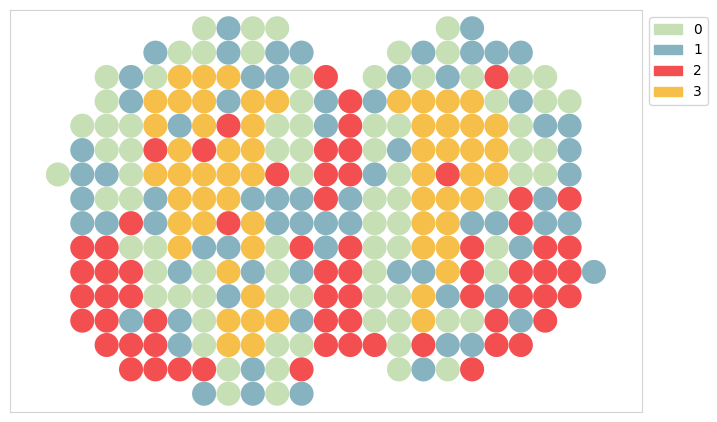

In [81]:
color_dict_domain = {'1': '#87B3C0', '0': '#C6DFB5', '3': '#F5BF4A', '2': '#F34F50'}
plot_frac_results(np.array(k_means_df_filter), domain_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/tangram_domains_pie_plot.jpg', color_dict=color_dict_domain)

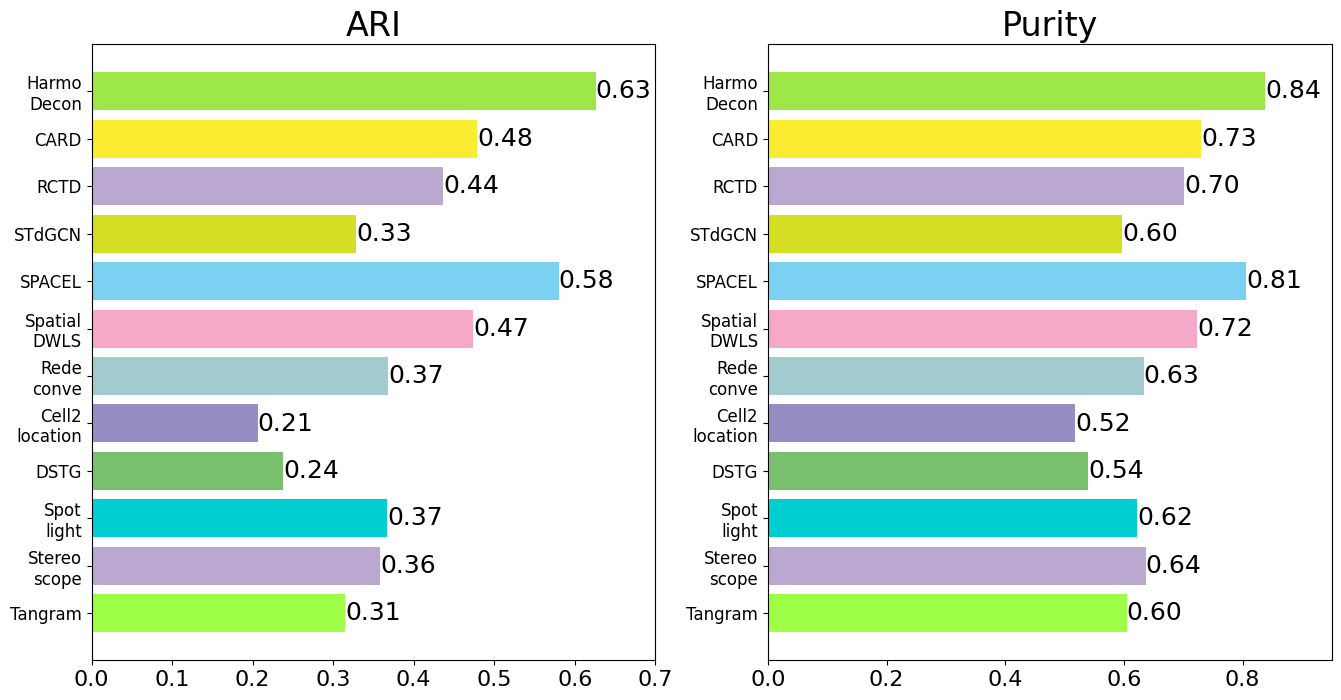

In [83]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

# Given list
colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1',"#BBA8D1", "#9dff46"]
# labels = ['HarmoDecon','SPACEL','StdGCN','Redeconve','RCTD','SpatialDWLS','CARD']
labels = ['Harmo\nDecon',
 'CARD',
 'RCTD',
 'STdGCN',
 'SPACEL',
 'Spatial\nDWLS',
 'Rede\nconve',
 'Cell2\nlocation',
 'DSTG',
 'Spot\nlight',
 'Stereo\nscope',
 'Tangram']
# ari_list = [0.63, 0.58, 0.33, 0.37, 0.44, 0.47, 0.48]

# purity_list = [0.84, 0.81, 0.60, 0.63, 0.70, 0.72, 0.73]

# Create a horizontal bar graph with custom colors
bars = axes[0].barh(labels[::-1], ari_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars:
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)

axes[0].set_title("ARI", fontsize=24)
axes[0].set_ylabel('', fontsize=14)  # Remove y-label title

bars_p = axes[1].barh(labels[::-1], pur_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars_p:
    width = bar.get_width()
    if width < 0:
        axes[1].text(0, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)
    else:
        axes[1].text(width, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)

axes[1].set_title("Purity", fontsize=24)
axes[1].set_ylabel('', fontsize=14)  # Remove y-label title

axes[0].set_yticklabels(labels[::-1], fontsize=12)  # Increase fontsize to 14
axes[0].set_xlim([0, 0.7])  # Increase fontsize to 14
axes[1].set_xlim([0, 0.95])  # Increase fontsize to 14
axes[1].set_yticklabels(labels[::-1], fontsize=12)  # Increase fontsize to 14
for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='x', labelsize=16)

plt.savefig(output_dir + '/barsh_2.jpg', dpi=300, bbox_inches='tight')
# Display the graph
plt.show()